### Installing and importing libraries

In [1]:
# Install packages needed
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install xgboost
!pip install kaggle

In [2]:
# Importing all packages
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score

### Loading and inspecting data

The dataset used in this notebook is hosted on Kaggle. To download it you will need to first create an API key and then run the following command.

In [3]:
!kaggle datasets download -d lakshmi25npathi/bike-sharing-dataset

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset
License(s): unknown
bike-sharing-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Now we extract the zip file to a folder named `bike-sharing-dataset`.

In [4]:
with zipfile.ZipFile("bike-sharing-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("bike-sharing-dataset")

**Load the data:** Loading the data into a `pandas DataFrame`. Note that there are three things that we could want to predict, the number of `casual` or `registered` users or the total `cnt`.

In [5]:
df = pd.read_csv("./bike-sharing-dataset/hour.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Checking the size of the DataFrame and store the column names in case they are needed.

In [6]:
print("Shape:", df.shape)
columns = df.columns
display(columns)

Shape: (17379, 17)


Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

Checking for NaNs and dtypes with `df.info()` and check de distribution of the values per column with `df.describe()`

In [7]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


None

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


Luckily the dataset does not contain missing values, so we do not need to use imputation techniques.

### Splitting train and testing

Since the data has a date associated I split it using the first year and a half. This is to mimic what would happen in real life, where you would have historical data and you would want to predict the future.

In [8]:
train_df = df[(df['yr'] == 0) | ((df['yr'] == 1) & (df['mnth'] <= 6))].copy()
test_df = df[~df.index.isin(train_df.index)].copy()

As mentioned before the data has three possible labels, for this notebook we will only predict the total number of users, therefore we drop the `casual` and `registered` columns and assign `cnt` as the label. Note that I use the `copy()` method to avoid any backpropagation of data changes from our analyses below.

In [9]:
X_train, y_train = train_df.drop(columns=["cnt","casual","registered"]).copy(), train_df["cnt"].copy()
X_test, y_test = test_df.drop(columns=["cnt","casual","registered"]).copy(), test_df["cnt"].copy()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(13003, 14) (13003,)
(4376, 14) (4376,)


### Data analysis

Here we plot a heatmap of the correlation matrix to understand how the features relate to each other. We can already see here that probably the most useful columns are: `temp`, `atemp`, `hr` and `hum` since all of them correlate with the output we want to predict. 

Note: I used only the training data in the analysis to ensure that all my decisions are based only on the training and do not "leak" anything before the final testing. 

<Axes: >

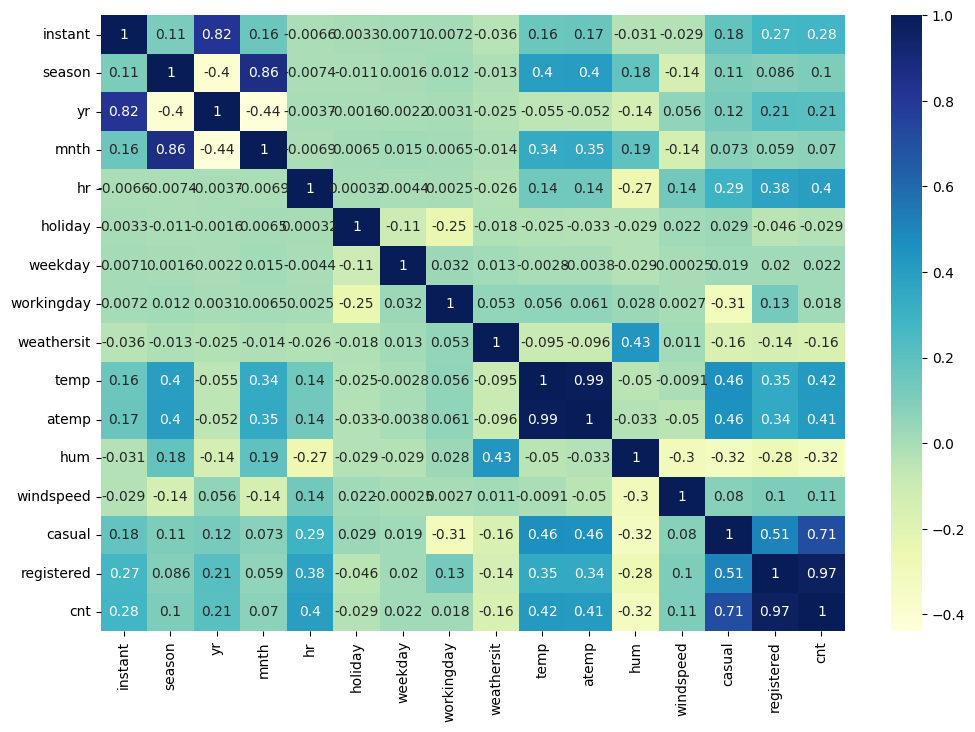

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

Since the data predicts rental bikes, I plot all the variables by date to see if there is any relation with the time of the year. 

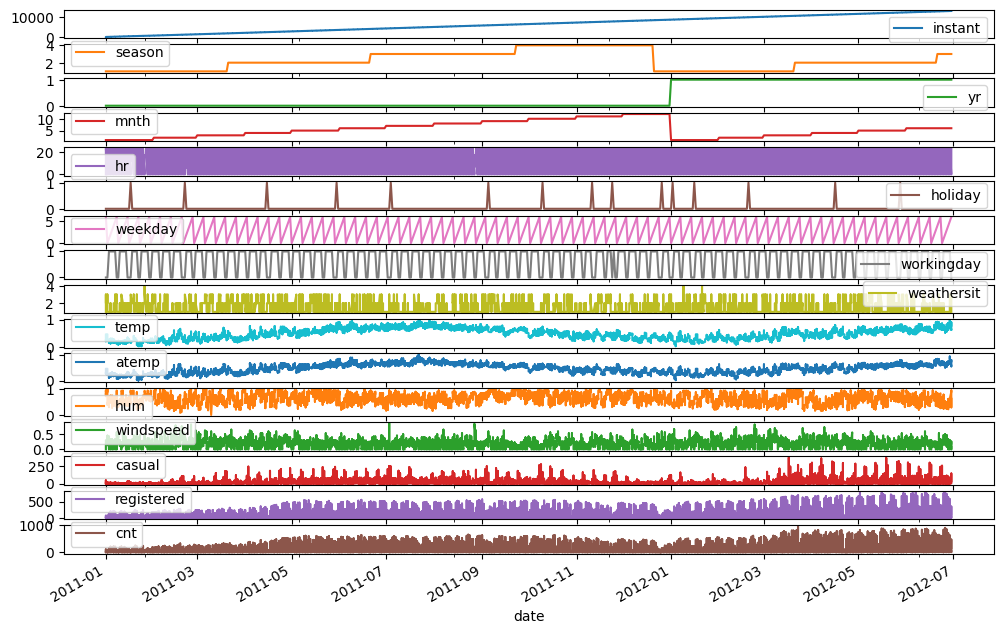

In [11]:
train_df['date'] = pd.to_datetime(train_df['dteday'])
_ = train_df.plot(subplots=True, x="date", figsize=(12, 8))

We can see that there is some seasonality, but most likely this is caused by the temperature recorded. Another thing that is expected is that the time of the date afects the number or rental bikes, so lets plot that too.

<Axes: xlabel='hr', ylabel='cnt'>

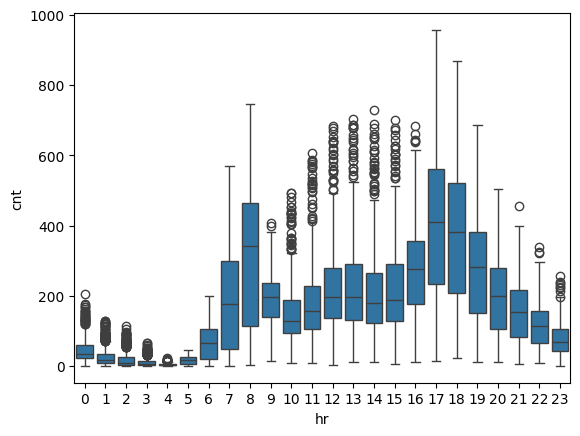

In [12]:
sns.boxplot(data=train_df, x='hr', y='cnt')

We can see that there are peaks in usage at commuting hours (7-9) and (17-18). Another interesting thing to consider is what is the daily change in bike rentals.

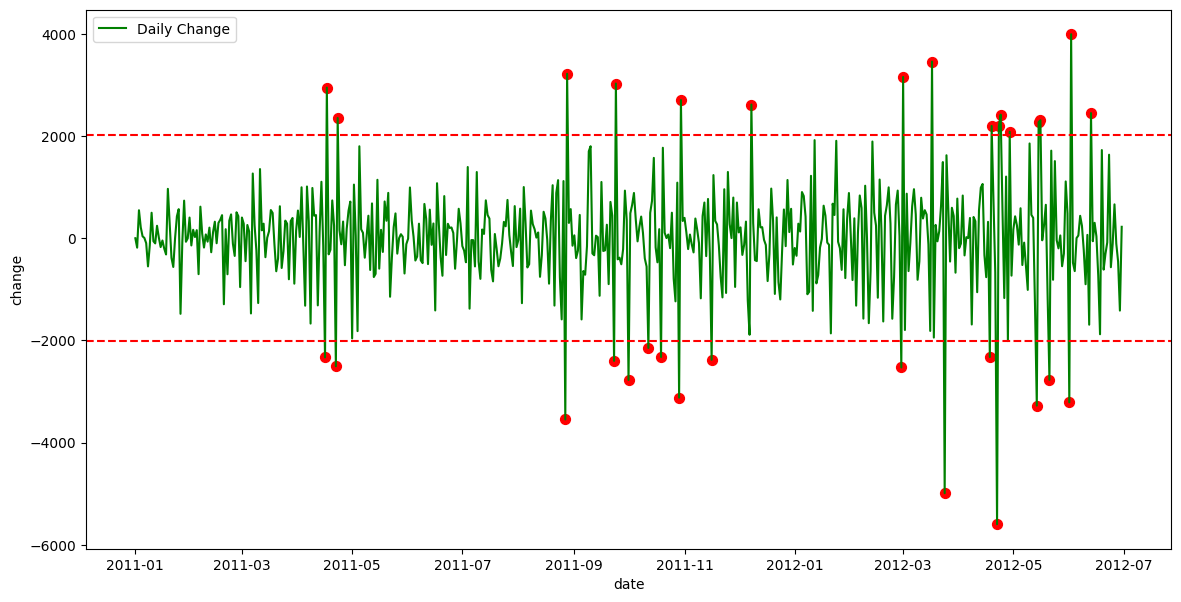

In [13]:
daily_data = train_df.groupby('date').agg({'cnt': 'sum'}).reset_index()
daily_data['change'] = daily_data['cnt'].diff()
daily_data['change'] = daily_data['change'].fillna(0)
threshold = daily_data['change'].std() * 2  # Threshold: 2 * standard deviation
anomalies = daily_data[abs(daily_data['change']) > threshold]

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(data=daily_data, x='date', y='change', ax=ax, label='Daily Change', color='green')
ax.scatter(anomalies['date'], anomalies['change'], color='red', label='Anomaly', s=50)
ax.axhline(threshold, color='red', linestyle='--', label='Positive Threshold')
ax.axhline(-threshold, color='red', linestyle='--', label='Negative Threshold')

This tells us that probably we could use data from the previous day to improve the predictions for the next day.

Total number of data points: 13003
Number of anomalies: 860
Percentage of anomalies: 6.61%


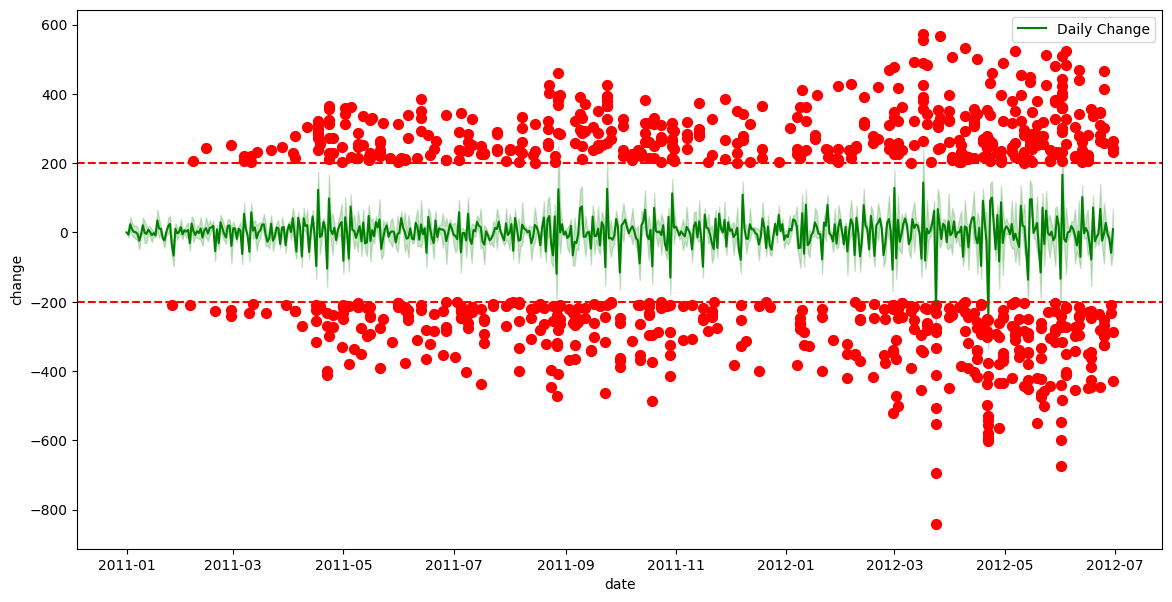

In [14]:
train_df['change'] = train_df['cnt'] - train_df['cnt'].shift(24)
train_df['change'] = train_df['change'].fillna(0)
threshold = train_df['change'].std() * 2  # Threshold: 2 * standard deviation
anomalies = train_df[abs(train_df['change']) > threshold]

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(data=train_df, x='date', y='change', ax=ax, label='Daily Change', color='green')
ax.scatter(anomalies['date'], anomalies['change'], color='red', label='Anomaly', s=50)
ax.axhline(threshold, color='red', linestyle='--', label='Positive Threshold')
ax.axhline(-threshold, color='red', linestyle='--', label='Negative Threshold')
print("Total number of data points:", train_df.shape[0])
print("Number of anomalies:", anomalies.shape[0])
print(f"Percentage of anomalies: {100*anomalies.shape[0]/train_df.shape[0]:.2f}%")

From this plot we can see that there are a lot more outliers than in the daily count, but the percentage of anomalies are still relatively small. And from the correlation matrix we can see that it could be extremely useful.

<Axes: >

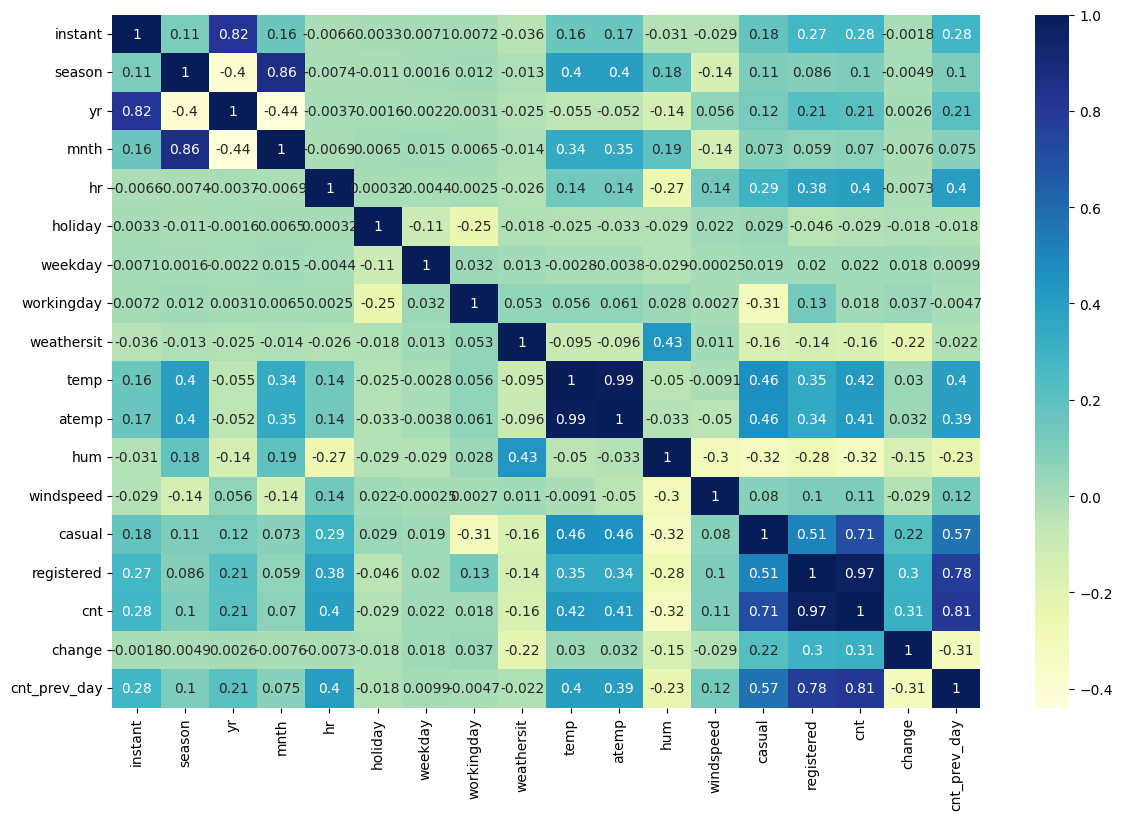

In [15]:
train_df['cnt_prev_day'] = train_df['cnt'].shift(24)
train_df['cnt_prev_day'] = train_df['cnt_prev_day'].fillna(0)

plt.figure(figsize=(14, 9))
sns.heatmap(train_df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

### Feature Engineering

The features in this dataset have already been preprocessed in some way, for example `temp`, `atemp`, `hum` and `windspeed` are already scaled between 0 and 1, the other features are ordinally encoded and there are no missing values. The only thing that we could try is to use one hot encoder instead of the ordinal encoder. I create two dataframes to test which encoding is better.

Additionally, from the data analysis we noticed that the count of the previous day could be useful so we will implement that into the pipeline.

In [16]:
class columnDropperTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

features_to_encode = [
    'season', 'mnth', 'hr', 
    'weekday', 'weathersit']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first',sparse_output=False), features_to_encode)
        ], 
        remainder="passthrough", 
        verbose_feature_names_out= False).set_output(transform="pandas")

X_train_transformed = X_train.copy()

X_train_transformed['cnt_prev_day'] = y_train.shift(24)
X_train_transformed['cnt_prev_day'] = X_train_transformed['cnt_prev_day'].fillna(0)
print(X_train_transformed.columns)

preprocessing_pipeline_1 = Pipeline([
    ("columnDropper", columnDropperTransformer(['dteday'])),
    ('preprocessor', preprocessor)
])

preprocessing_pipeline_2 = Pipeline([
    ("columnDropper", columnDropperTransformer(['dteday'])),
])

preprocessing_pipeline_3 = Pipeline([
    ("columnDropper", columnDropperTransformer(['dteday'])),
    ('pca', PCA())
])

X_transformed_1 = preprocessing_pipeline_1.fit_transform(X_train_transformed)
X_transformed_2 = preprocessing_pipeline_2.fit_transform(X_train_transformed)
X_transformed_3 = preprocessing_pipeline_3.fit_transform(X_train_transformed)

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt_prev_day'],
      dtype='object')


### Model Selection

Here, we test several algorithms with different parameter settings using grid search. The grid search uses some parameter settings, but the parameters selected are not extremely optimised.

In [17]:
models = {
    "Random Forest": RandomForestRegressor(random_state=0),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(random_state=0, early_stopping=False),
    'ElasticNet': ElasticNet(random_state=0),
    'xgb': xgb.XGBRegressor(random_state=0)
}

param_grids = {
    "Random Forest": {"n_estimators": [10, 20, 50, 100]},
    "Hist Gradient Boosting": {"max_iter": [10, 20, 50, 100, 300]},
    'ElasticNet': {"alpha": [0.01, 0.1, 1], "l1_ratio": [0.2, 0.5, 0.8, 1.0]}, # l1_ratio == 1.0 is equivalent to Lasso
    'xgb':{"n_estimators": [10, 20, 50, 100]}
}

cv = KFold(n_splits=4, shuffle=False)

for X_transformed in [X_transformed_1,X_transformed_2,X_transformed_3]:
    print("============")
    for name, model in models.items():
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            return_train_score=True,
            cv=cv,
            n_jobs=-1,
        ).fit(X_transformed, y_train)
        print(name, grid_search.best_params_, grid_search.best_score_)

Random Forest {'n_estimators': 100} 0.7237796612387587
Hist Gradient Boosting {'max_iter': 50} 0.7663063586806613


/home/mariohevia/miniconda3/envs/envJupyter/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.366e+07, tolerance: 2.805e+04
  model = cd_fast.enet_coordinate_descent(
/home/mariohevia/miniconda3/envs/envJupyter/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e+07, tolerance: 2.819e+04
  model = cd_fast.enet_coordinate_descent(
/home/mariohevia/miniconda3/envs/envJupyter/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

ElasticNet {'alpha': 0.01, 'l1_ratio': 0.2} 0.689208549248405
xgb {'n_estimators': 20} 0.729716345667839
Random Forest {'n_estimators': 20} 0.7380497136926296
Hist Gradient Boosting {'max_iter': 50} 0.7970622263403604


/home/mariohevia/miniconda3/envs/envJupyter/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.810e+07, tolerance: 2.619e+04
  model = cd_fast.enet_coordinate_descent(
/home/mariohevia/miniconda3/envs/envJupyter/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.371e+07, tolerance: 2.819e+04
  model = cd_fast.enet_coordinate_descent(
/home/mariohevia/miniconda3/envs/envJupyter/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

ElasticNet {'alpha': 0.1, 'l1_ratio': 0.8} 0.6327096252754385
xgb {'n_estimators': 20} 0.7482473403215408
Random Forest {'n_estimators': 100} 0.601171686467757
Hist Gradient Boosting {'max_iter': 300} 0.6959800996184582
ElasticNet {'alpha': 0.1, 'l1_ratio': 0.8} 0.6324359538465609
xgb {'n_estimators': 20} 0.6192070245742798


Now, I combined the two best models using Voting to test if this resulted in a performance improvement.

In [18]:
# Testing whether the best two regressors combined have better result
reg1 = HistGradientBoostingRegressor(early_stopping=False, random_state=0, max_iter=50)
reg2 = xgb.XGBRegressor(random_state=0)
v_reg = VotingRegressor(estimators=[('hgb', reg1), ('rf', reg2)])
float(cross_val_score(v_reg, X_transformed_2, y_train, cv=cv, scoring='r2').mean())

0.7723058174761523

There was no noticeable improvement, therefore I will continue only with `HistGradientBoostingRegressor`.

### Hyperparameter tuning

In [19]:
model = HistGradientBoostingRegressor(
        random_state=0, early_stopping=False)
param_grid = {
    "learning_rate": [0.01, 0.1],  # Lower values for more stable learning
    "max_iter": [100, 200],  # Number of boosting iterations
    "max_leaf_nodes": [15, 31],  # Controls tree complexity
    "min_samples_leaf": [10, 20],  # Minimum samples per leaf
    "l2_regularization": [0, 0.5],  # Regularization strength
    "max_depth": [None, 5],  # Depth of each tree (None means unlimited)
    "loss": ["squared_error", "absolute_error"],  # Loss function (MSE or MAE)
}
cv = KFold(n_splits=4, shuffle=False)
grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            return_train_score=True,
            cv=cv,
            n_jobs=-1,
        ).fit(X_transformed_2, y_train)
print(grid_search.best_params_, grid_search.best_score_)

final_pipeline = preprocessing_pipeline_2
final_model = HistGradientBoostingRegressor(random_state=0, early_stopping=False, **grid_search.best_params_)
final_model.fit(X_transformed_2, y_train)

{'l2_regularization': 0.5, 'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20} 0.8301298940852887


HistGradientBoostingRegressor(early_stopping=False, l2_regularization=0.5,
                              loss='absolute_error', random_state=0)

### Testing

Before using the testing data I want to evaluate on the training data. We would expect to have a good performance, since the model have seen all the data point, but we wouldn't want to have perfect scores, since that would only indicate overfitting. I also plot the actual vs. predicted counts to visually assess model accuracy. 

Mean Absolute Error (MAE): 23.31
Mean Squared Error (MSE): 1688.57
R-squared (R²): 0.93
Mean Absolute Percentage Error (MAPE): 0.32
Explained Variance Score: 0.93


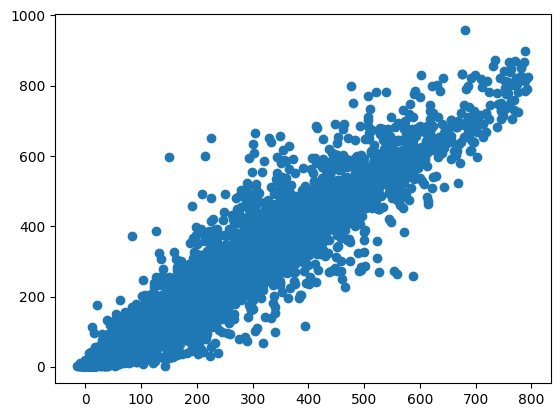

In [20]:
train_predictions = final_model.predict(X_transformed_2)
_ = plt.scatter(train_predictions, y_train)

mae = mean_absolute_error(y_train, train_predictions)
mse = mean_squared_error(y_train, train_predictions)
r2 = r2_score(y_train, train_predictions)
mape = mean_absolute_percentage_error(y_train, train_predictions)
explained_variance = explained_variance_score(y_train, train_predictions)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
print(f"Explained Variance Score: {explained_variance:.2f}")

Visually checking how the predicted values compare with the real values. We can see that the align pretty well, but this is expected because I am training on the same data I am predicting.

Again, I visualise the predictions vs the real data but now based on the date

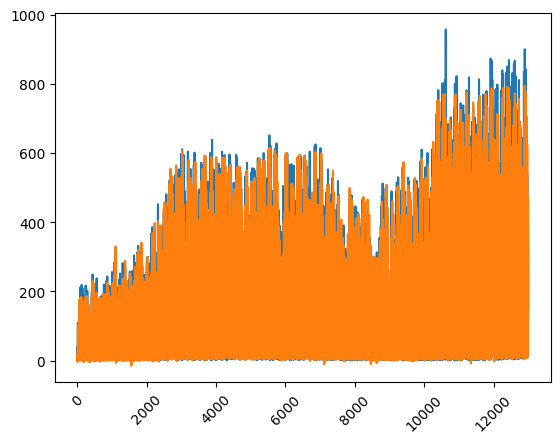

In [21]:
plt.plot(X_train["instant"], y_train)
plt.plot(X_train["instant"], train_predictions)
_ = plt.xticks(rotation=45)

After all the training has been done, I evaluate with the test data. This time the plot shows that the predictions are not as good as on the training data (expected) but it is still reasonably good.

Mean Absolute Error (MAE): 51.24
Mean Squared Error (MSE): 6882.47
R-squared (R²): 0.86
Mean Absolute Percentage Error (MAPE): 0.41
Explained Variance Score: 0.87


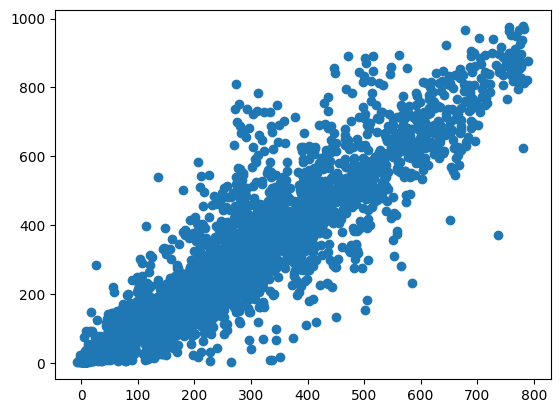

In [22]:
X_test_transform = X_test.copy()
X_test_transform['cnt_prev_day'] = y_test.shift(24)
X_test_transform['cnt_prev_day'] = X_test_transform['cnt_prev_day'].fillna(0)
X_test_transform = final_pipeline.fit_transform(X_test_transform)

predictions = final_model.predict(X_test_transform)
plt.scatter(predictions, y_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
print(f"Explained Variance Score: {explained_variance:.2f}")

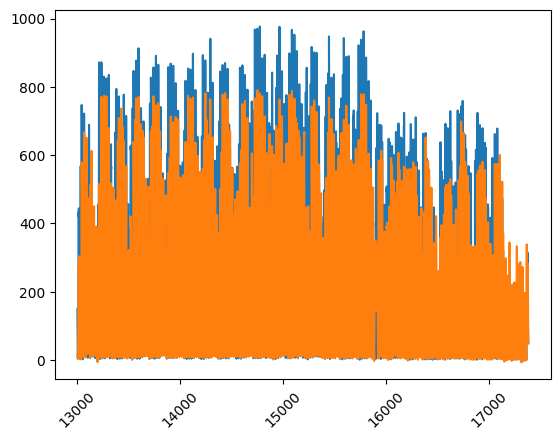

In [23]:
plt.plot(X_test["instant"], y_test)
plt.plot(X_test["instant"], predictions)
_ = plt.xticks(rotation=45)

### Model Interpretation

In [24]:
r = permutation_importance(final_model, X_transformed_2, y_train,
                           n_repeats=30,
                           random_state=0)


for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_transformed_2.columns[i]:<8}\t"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

hr      	0.491 +/- 0.007
cnt_prev_day	0.429 +/- 0.006
workingday	0.091 +/- 0.002
weekday 	0.074 +/- 0.002
instant 	0.071 +/- 0.002
weathersit	0.038 +/- 0.001
hum     	0.033 +/- 0.001
temp    	0.030 +/- 0.001
atemp   	0.015 +/- 0.001
windspeed	0.002 +/- 0.000
season  	0.002 +/- 0.000
mnth    	0.001 +/- 0.000
holiday 	0.000 +/- 0.000


Here, I check the feature importance.